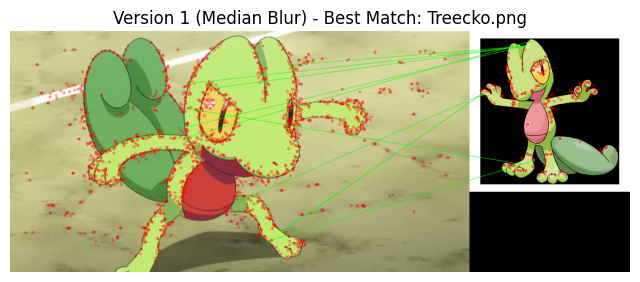

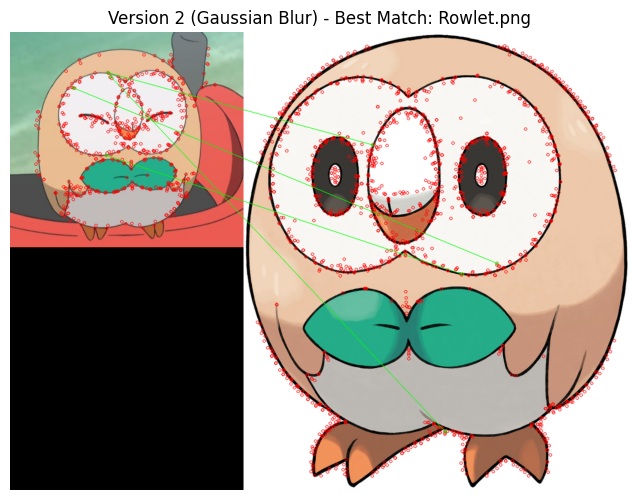

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

target_path = './Images/Object.png'
data_folder = './Images/Data/'

def preprocess_v1(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eq = cv2.equalizeHist(gray)
    blur = cv2.medianBlur(eq, 5)
    return blur

def preprocess_v2(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eq = cv2.equalizeHist(gray)
    blur = cv2.GaussianBlur(eq, (3, 3), 0)
    return blur

def find_best_match(preprocess_func, title):
    target = cv2.imread(target_path)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
    target_gray = preprocess_func(target)
    

    akaze = cv2.AKAZE_create()
    kp_target, desc_target = akaze.detectAndCompute(target_gray, None)
    desc_target = np.float32(desc_target)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, tree=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    best_match_count = 0
    best_match_img = None
    best_match_title = ""

    for filename in os.listdir(data_folder):
        img_path = os.path.join(data_folder, filename)
        scene = cv2.imread(img_path)
        scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
        scene_gray = preprocess_func(scene)

        kp_scene, desc_scene = akaze.detectAndCompute(scene_gray, None)
        desc_scene = np.float32(desc_scene)
        matches = flann.knnMatch(desc_target, desc_scene, k=2)

        good = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good.append([m])

        if len(good) > best_match_count:
            best_match_count = len(good)
            best_match_img = cv2.drawMatchesKnn(
                target, kp_target,
                scene, kp_scene,
                good, None,
                matchColor=[0, 255, 0],
                singlePointColor=[255, 0, 0]
            )
            best_match_title = filename

    plt.figure(figsize=(8, 6))
    plt.imshow(best_match_img)
    plt.title(f'{title} - Best Match: {best_match_title}')
    plt.axis(False)
    plt.show()

find_best_match(preprocess_v1, "Version 1 (Median Blur)")
target_path = 'Images/Object2.png'
find_best_match(preprocess_v2, "Version 2 (Gaussian Blur)")